# Dataset creation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# TF-IDF vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # Check with bigrams
    max_features=5000,
    stop_words='english'  # Additional filtration
)
X = tfidf.fit_transform(df)
y = dataset['Liked']

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting by train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting by train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model creation

## Baseline: Logistic regression

base model predictions

In [ ]:
model = LogisticRegression(
    C=1.0,                # Regularization Power
    penalty='l2',         # L2 regularization
    solver='liblinear',   # Optimizer
    class_weight='balanced'
)
model.fit(X_train, y_train)

# Model metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        96
           1       0.87      0.70      0.78       104

    accuracy                           0.79       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.79      0.79       200



track this results to `mlflow`

Initialized MLflow to track repo "PigStep/Restourant-Sentimental-Analys-ML-based"

Repository PigStep/Restourant-Sentimental-Analys-ML-based initialized!

Metric tracking success
confusion_matrix generated
roc_curve generated
Model logged to runs:/29c294d46e47442197cff90793b83148/my_model
🏃 View run baseline Logistic Regression at: https://dagshub.com/PigStep/Restourant-Sentimental-Analys-ML-based.mlflow/#/experiments/0/runs/29c294d46e47442197cff90793b83148
🧪 View experiment at: https://dagshub.com/PigStep/Restourant-Sentimental-Analys-ML-based.mlflow/#/experiments/0


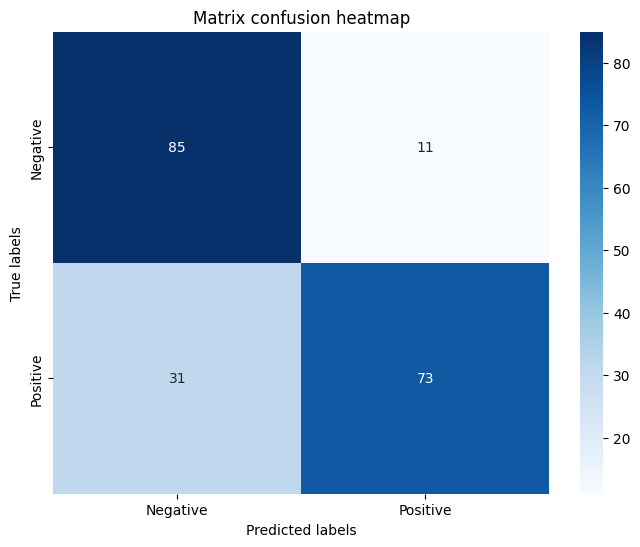

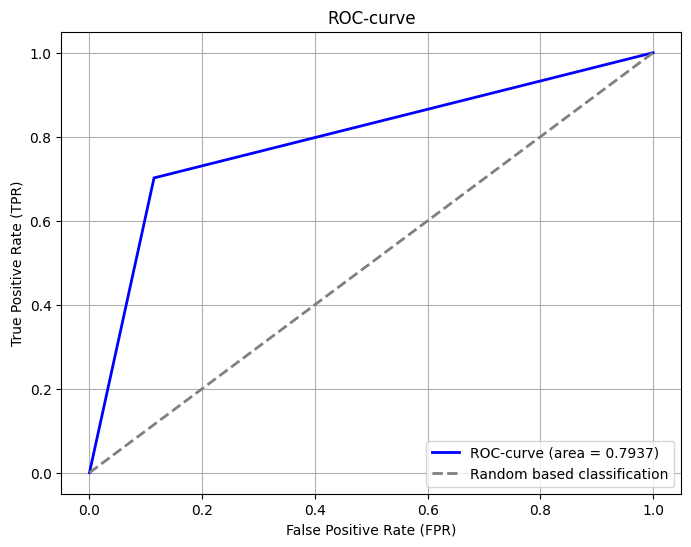

In [ ]:
import dagshub
from mlflow.models import infer_signature

dagshub.init(repo_owner='PigStep', repo_name='Restourant-Sentimental-Analys-ML-based', mlflow=True)

with mlflow.start_run(run_name="baseline Logistic Regression") as run:
  push_metrics(y_pred,y_test)
  push_confusion_matrix(y_pred,y_test)
  push_roc_curve(y_pred,y_test)

  mlflow.log_param('C', 1)
  mlflow.log_param('penalty', 'l2')
  mlflow.log_param('solver','liblinear')
  mlflow.log_param('class_weight','balanced')

  mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="my_model",
        input_example=X_train[:5],
        signature=infer_signature(X_train, model.predict(X_train))
    )

  print(f"Model logged to runs:/{run.info.run_id}/my_model")

### Feature Grid Search

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
def run_grid_search(param_grid):
  pipeline = Pipeline([
      ('tfidf', TfidfVectorizer()),
      ('clf', LogisticRegression(class_weight='balanced'))
  ])

  grid_search = GridSearchCV(
      pipeline,
      param_grid,
      cv=5,
      scoring='f1_weighted',    # Optimizing by f1
      n_jobs=-1,
      verbose=1
  )

  grid_search.fit(dataset['Review'], dataset['Liked'])

  print("Best params:", grid_search.best_params_)
  print("Best F1-score:", grid_search.best_score_)

In [ ]:
param_grid = {
      'tfidf__ngram_range': [(1, 1), (1, 2)],  # Only words or with bigrams
      'tfidf__max_features': [1000, 5000],
      'clf__C': [0.1, 1.0, 10.0],
      'clf__penalty': ['l1', 'l2'],             # Type of regularization
      'clf__solver': ['liblinear', 'saga']      # Optimization algoriphm
  }

# run_grid_search(param_grid)
# Best params: {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
# Best F1-score: 0.8128993073820239

param_grid = {
      'tfidf__ngram_range': [(1, 2), (1, 3)],
      'tfidf__max_features': [5000, 7000, 10000],
      'clf__C': [10.0, 15.00, 25.00],
  }
# run_grid_search(param_grid)
# Best params: {'clf__C': 25.0, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}
# Best F1-score: 0.8149600538151471

param_grid = {
      'tfidf__ngram_range': [(1, 2)],
      'tfidf__max_features': [6000, 7000, 8000],
      'clf__C': [25.00, 35.00, 50.00],
  }
# run_grid_search(param_grid)
# Best params: {'clf__C': 35.0, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}
# Best F1-score: 0.8199671874750051

param_grid = {
      'tfidf__ngram_range': [(1, 2)],
      'tfidf__max_features': range(6000,8000,100),
      'clf__C': range(25,50,5),
  }
# run_grid_search(param_grid)
# Best params: {'clf__C': 30, 'tfidf__max_features': 6600, 'tfidf__ngram_range': (1, 2)}
# Best F1-score: 0.8219659874750981

In [ ]:
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_[0]
top_positive = sorted(zip(coefs, feature_names), reverse=True)[:10]
top_negative = sorted(zip(coefs, feature_names))[:10]

print("Top-10 positive n-grams:")
for score, word in top_positive:
    print(f"{word}: {score:.2f}")
print('')
print("Top-10 negative n-grams:")
for score, word in top_negative:
    print(f"{word}: {score:.2f}")

In [ ]:
pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(
          preprocessor=preprocessText,
          ngram_range=(1, 2),
          max_features=6600
      )),
      ('clf', LogisticRegression(
          C=30,
          penalty="l2",
          solver="saga",
          class_weight='balanced'
          ))
  ])

#Create "pure" data for pipeline
dataset = pd.read_csv("/root/.cache/kagglehub/datasets/hj5992/restaurantreviews/versions/1/Restaurant_Reviews.tsv", sep="\t")
X = dataset['Review']
y = dataset['Liked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
import joblib

# Define the filename for your pipeline
filename = 'restaurant_review_pipelineLR.joblib'

# Save the pipeline to the file
joblib.dump(pipeline, filename)

print(f"Pipeline saved to {filename}")